In [1]:
__author__ = 'Alice Jacques <alice.jacques@noirlab.edu>, Steve Pothier <steve.pothier@noirlab.edu>, Adam Bolton <adam.bolton@noirlab.edu>'
__version__ = '20230610' # yyyymmdd; 
__datasets__ = ['sdss_dr16','boss_dr16','desi_edr']  
__keywords__ = ['spectroscopy', 'HowTo', 'sdss spectra', 'desi spectra', 'tutorial']

# How to use SPARCL
SPectra Analysis and Retrievable Catalog Lab (SPARCL)

### Table of contents
* [Goals & Summary](#goalssummary)
* [If necessary, install the most recent version of the SPARCL Client](#install)
* [Imports and setup](#imports)
* [Authentication](#authentication)
* [Data sets available in SPARCL](#datasets)
* [Get default field names](#defaultfieldnames)
* [Get all field names](#allfieldnames)
* [Data discovery I: using SPARCL's <tt>client.find()</tt> method](#datadiscoveryI)
* [Data discovery II: using Data Lab's <tt>sparcl.main</tt> table](#datadiscoveryII)
* [Retrieve records by <tt>sparcl_id</tt> using <tt>client.retrieve()</tt>](#retrieve)
* [Retrieve records by <tt>specid</tt> using <tt>client.retrieve_by_specid()</tt>](#retrieve_specid)
* [Reorder spectrum records](#reorder)
* [Access fields in records](#access)
* [Convert retrieved output to Pandas DataFrame or Spectrum1D object](#convert)
* [Plot spectra](#plot)
* [Use <tt>client.missing()</tt> to find missing IDs in the SPARCL database](#missing)

<a class="anchor" id="goalssummary"></a>
## Goals & Summary 

SPARCL (SPectra Analysis and Retrievable Catalog Lab) is an online service for discovery and retrieval of one-dimensional optical-infrared spectra. SPARCL is designed to work for large survey datasets containing many millions of spectra, and to provide access to multiple different data sets through common methods. For more information, see the [SPARCL User Guide](https://astrosparcl.datalab.noirlab.edu/static/SPARCLUserManual.pdf).

This notebook provides a basic introduction to using the SPARCL client (or sparclclient) to find and retrieve spectroscopic data within a Python notebook context. The sparclclient connects to the SPARCL server at [NSF's NOIRLab](https://noirlab.edu/public/) and provides access to the contents of the SPARCL database.

To see the current data sets and number of spectra available in the SPARCL database, please visit the [SPARCL summary page](https://astrosparcl.datalab.noirlab.edu/sparc/).

To get the latest sparclclient documentation, visit the [sparclclient readthedocs site](https://sparclclient.readthedocs.io/en/latest/).

Feedback on SPARCL (questions, comments, science use cases, feature requests, bug reports, confusing error messages, etc.) can be submitted to datalab-spectro@noirlab.edu. For bug reports and confusing error messages, it's helpful if you include: a log of *what you did*, *the result you got*, and *the result you expected*.

<a class="anchor" id="install"></a>
### If necessary, install the most recent version of the SPARCL Client:
If you are using the Astro Data Lab Jupyter notebook server, you do not need to run this cell.
### NOTE: After installing the most recent version, please restart your kernel.

In [8]:
## Uncomment and run the following only if SPARCL client is not already installed
#!pip install sparclclient

<a class="anchor" id="imports"></a>
## Imports and setup

In [2]:
# SPARCL imports
from sparcl.client import SparclClient

# 3rd party imports
from time import time
import numpy as np
import astropy.units as u
from specutils import Spectrum1D
from astropy.nddata import InverseVariance
from astropy.convolution import convolve, Gaussian1DKernel
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Data Lab imports
from dl import queryClient as qc
from dl import authClient as ac
from getpass import getpass

# plots default setup
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (14,8)

<a class="anchor" id="authentication"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [4]:
#ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

#### We now create a SPARCL client and print out version information:

In [3]:
client = SparclClient()
client

(sparclclient:1.2.0b4, api:9.0, https://sparclstage.datalab.noirlab.edu/sparc, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

In [6]:
help(SparclClient())

Help on SparclClient in module sparcl.client object:

class SparclClient(builtins.object)
 |  SparclClient(*, url='https://astrosparcl.datalab.noirlab.edu', verbose=False, connect_timeout=1.1, read_timeout=5400)
 |  
 |  Provides interface to SPARCL Server.
 |  When using this to report a bug, set verbose to True. Also print
 |  your instance of this.  The results will include important info
 |  about the Client and Server that is usefule to Developers.
 |  
 |  Args:
 |      url (:obj:`str`, optional): Base URL of SPARC Server. Defaults
 |          to 'https://astrosparcl.datalab.noirlab.edu'.
 |  
 |      verbose (:obj:`bool`, optional): Default verbosity is set to
 |          False for all client methods.
 |  
 |      connect_timeout (:obj:`float`, optional): Number of seconds to
 |          wait to establish connection with server. Defaults to
 |          1.1.
 |  
 |      read_timeout (:obj:`float`, optional): Number of seconds to
 |          wait for server to send a response. Ge

<a class="anchor" id="datasets"></a>
## Data sets available in SPARCL
List all currently available data sets from the server/url associated with client

In [7]:
client.all_datasets

{'BOSS-DR16', 'DESI-EDR', 'SDSS-DR16'}

<a class="anchor" id="defaultfieldnames"></a>
## Get default field names
Gets fields tagged as 'default' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'default' fields across all datasets currently available in the SPARC database.

In [8]:
client.get_default_fields?

Signature: client.get_default_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'default' that are in DATASET_LIST.
These are the fields used for the DEFAULT value of the include
parameter of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get the default fields. Defaults to None, which
        will return the intersection of default fields in all
        data sets hosted on the SPARC database.

Returns:
    List of fields tagged as 'default' from DATASET_LIST.

Example:
    >>> client = SparclClient()
    >>> client.get_default_fields()
    ['flux', 'id', 'wavelength']
File:      ~/anaconda3/lib/python3.8/site-packages/sparcl/client.py
Type:      method

In [9]:
client.get_default_fields()

['dec', 'flux', 'ra', 'sparcl_id', 'specid', 'wavelength']

<a class="anchor" id="allfieldnames"></a>
## Get all field names
Gets fields tagged as 'all' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'all' fields across all datasets currently available in the SPARC database.

In [10]:
client.get_all_fields?

Signature: client.get_all_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'all' that are in DATASET_LIST.
These are the fields used for the ALL value of the include parameter
of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get all fields. Defaults to None, which
        will return the intersection of all fields in all
        data sets hosted on the SPARC database.

Returns:
    List of fields tagged as 'all' from DATASET_LIST.

Example:
    >>> client = SparclClient()
    >>> client.get_all_fields()
    ['data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'fiberid', 'flux', 'id', 'instrument', 'ivar', 'mask', 'mjd', 'model', 'plate', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'run1d', 'run2d', 'site', 'sky', 'specid', 'specobjid', 'specprimary', 'spectype', 'targetid', 'telescope', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']
File:      ~/anaconda3/lib/python3.8/site

In [11]:
print(sorted(client.get_all_fields()))

['data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'instrument', 'ivar', 'mask', 'model', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'survey', 'targetid', 'telescope', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']


In [12]:
print(sorted(client.get_all_fields(dataset_list=['SDSS-DR16', 'BOSS-DR16'])))

['ancillary_target1', 'ancillary_target2', 'anyandmask', 'anyormask', 'bluefiber', 'boss_specobj_id', 'boss_target1', 'boss_target2', 'calibflux', 'calibflux_ivar', 'chi68p', 'chunk', 'class_noqso', 'class_person', 'comments_person', 'cx', 'cy', 'cz', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'deredsn2', 'designid', 'dof', 'eboss_target0', 'eboss_target1', 'eboss_target2', 'eboss_target_id', 'elodie_bv', 'elodie_dof', 'elodie_feh', 'elodie_filename', 'elodie_logg', 'elodie_object', 'elodie_rchi2', 'elodie_sptype', 'elodie_teff', 'elodie_z', 'elodie_z_err', 'elodie_z_modelerr', 'exptime', 'fiberid', 'firstrelease', 'flux', 'fluxobjid', 'fracnsighi', 'fracnsiglo', 'fracnsigma', 'instrument', 'ivar', 'lambda_eff', 'legacy_target1', 'legacy_target2', 'marvels_target1', 'marvels_target2', 'mask', 'mjd', 'model', 'npoly', 'nspecobs', 'nturnoff', 'objid', 'plate', 'plateid', 'platequality', 'platerun', 'platesn2', 'primtarget', 'programname', 'ra', 'rchi2', 'rchi2dif

In [13]:
print(sorted(client.get_all_fields(dataset_list=['DESI-EDR'])))

['bgs_target', 'chi2', 'cmx_target', 'coadd_fiberstatus', 'coadd_numexp', 'coadd_numnight', 'coadd_numtile', 'coeff', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'deltachi2', 'desi_target', 'exptime', 'fa_target', 'fa_type', 'firstnight', 'flux', 'healpix', 'instrument', 'ivar', 'lastnight', 'mask', 'mean_delta_x', 'mean_delta_y', 'mean_fiber_dec', 'mean_fiber_ra', 'mean_mjd', 'mean_psf_to_fiber_specflux', 'model', 'mws_target', 'ncoeff', 'npixels', 'numobs_init', 'objtype', 'obsconditions', 'plate_dec', 'plate_ra', 'pmdec', 'pmra', 'priority_init', 'program', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'ref_epoch', 'rms_delta_x', 'rms_delta_y', 'scnd_target', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'spgrpval', 'std_fiber_dec', 'std_fiber_ra', 'subpriority', 'subtype', 'survey', 'sv1_bgs_target', 'sv1_desi_target', 'sv1_mws_target', 'sv1_scnd_target', 'sv2_bgs_target', 'sv2_desi_target', 'sv2_mws_target', 'sv2_scnd_target', 'sv3_bgs_t

<a class="anchor" id="datadiscoveryI"></a>
## Data discovery I: using SPARCL's `client.find()` method
The first way you can discover your data is by using SPARCL's `client.find()` method, which allows you to find records in the SPARCL database based on certain parameters passed to the function. Only Core fields may be in the `outfields` and `constraints` parameters. The descriptions for all fields, including Core fields, is located [here](https://astrosparcl.datalab.noirlab.edu/sparc/sfc/). The SPARCL Core fields constraint types are:


| Field name       | Constraint type | Example |
|:----------------|:---------------|:-------|
| data_release     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['DESI-EDR', 'BOSS-DR16', 'SDSS-DR16']
| datasetgroup     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['DESI', 'SDSS_BOSS']
| dateobs_center   | Range of values | ['2013-03-14T10:16:17Z',<br>'2014-05-24T12:10:00Z']
| dec              | Range of values | [2.03, 7.76]
| exptime          | Range of values | [3603.46, 3810.12]
| instrument       | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['SDSS', 'BOSS', 'DESI']
| ra               | Range of values (may not<br>"wrap" around RA=0) | [44.53, 47.96]
| redshift         | Range of values | [0.5, 0.9]
| redshift_err     | Range of values | [0.000225, 0.000516]
| redshift_warning | List of values  | [0, 3, 5]
| sparcl_id               | List of values (but not<br>intended for data discovery) | ['00001658-460c-4da1-987d-e493d8c9b89b',<br>'000017b6-56a2-4f87-8828-3a3409ba1083']
| site             | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) |  ['apo', 'kpno']
| specid           | List of values | [6988698046080241664, 6971782884823945216]
| spectype         | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['GALAXY', 'STAR', 'QSO']
| specprimary      | List of values (but typically<br>would only include 1 if<br>being used for data<br>discovery constraints) | [1]
| targetid         | List of values | [1237679502171374316, 1237678619584692841]
| telescope        | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['sloan25m', 'kp4m']
| wavemin          | Range of values | [3607, 3608]
| wavemax          | Range of values | [10363, 10364]

In [14]:
client.find?

Signature:
client.find(
    outfields=None,
    *,
    constraints={},
    limit=500,
    sort=None,
    verbose=None,
)
Docstring:
Find records in the SPARC database.

Args:
    outfields (:obj:`list`, optional): List of fields to return.
        Only CORE fields may be passed to this parameter.
        Defaults to None, which will return only the sparcl_id
        and _dr fields.

    constraints (:obj:`dict`, optional): Key-Value pairs of
        constraints to place on the record selection. The Key
        part of the Key-Value pair is the field name and the
        Value part of the Key-Value pair is a list of values.
        Defaults to no constraints. This will return all records in the
        database subject to restrictions imposed by the ``limit``
        parameter.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500.

    sort (:obj:`list`, optional): Comma separated list of fields
        to sort by. Defaults to None. (no sorting

#### Define the fields we want returned (`outfields`) and the constraints (`constraints`):

In [15]:
out = ['sparcl_id', 'ra', 'dec', 'redshift', 'spectype', 'data_release', 'redshift_err']
cons = {'spectype': ['GALAXY'],
        'redshift': [0.5, 0.9]}

#### Execute the `client.find()` method with our parameters:
The `limit` argument here is being used for demonstration purposes only, and simply returns only the first 20 results here.

In [48]:
found_I = client.find(outfields=out, constraints=cons, limit=20)
["%s, %s, %f, %f, %f" % (f.sparcl_id, f.data_release, f.ra, f.redshift, f.redshift_err)
 for f in found_I.records]

['00000f0b-07db-4234-892a-6e347db79c89, BOSS-DR16, 345.803810, 0.781320, 0.000203',
 '000028ab-9342-4884-9e25-941e98c97671, BOSS-DR16, 187.385010, 0.646126, 0.000220',
 '00004014-212e-43e6-9eb2-205e3be21759, BOSS-DR16, 119.189000, 0.553376, 0.000470',
 '0000403e-51da-43b0-a0e9-e806ea31ca9e, BOSS-DR16, 355.400840, 0.596648, 0.000362',
 '00004bb4-984e-4bf0-865c-29b135947b58, SDSS-DR16, 45.353743, 0.801205, 13.405861',
 '00005d85-beff-4b47-8360-420a554f6ae3, DESI-EDR, 225.936179, 0.818668, 0.000066',
 '000068f6-0491-418f-996b-6c6b838743a1, BOSS-DR16, 143.604520, 0.551550, 0.000152',
 '000097ff-817b-4490-83fc-5ba0e93569ec, BOSS-DR16, 114.816060, 0.605486, 0.000194',
 '00009fca-b03c-430c-8cd7-399314525ade, DESI-EDR, 218.161502, 0.843644, 0.000046',
 '0000a764-e886-43d7-896e-49652e31d812, BOSS-DR16, 126.480260, 0.649327, 0.000167',
 '0000ace8-a353-45b1-8f32-287069a27fa8, BOSS-DR16, 140.983180, 0.593962, 0.000173',
 '0000c61b-4b11-48d5-bd74-ed04d69a12bb, DESI-EDR, 270.676519, 0.695427, 0.0000

<a class="anchor" id="datadiscoveryII"></a>
## Data discovery II: using Data Lab's `sparcl.main` table
The second way you can discover your data is by querying the `sparcl.main` table hosted at Astro Data Lab. This table contains the following columns:


In [18]:
print(qc.schema('sparcl.main'))


Schema: sparcl
 Table: main

     Column Name   Description
     -----------   -----------
            elon   Ecliptic longitude
            elat   Ecliptic latitude
            glon   Galactic longitude
            glat   Galactic latitude
        redshift   Observed redshift, or radial velocity in units of redshift
              ra   Right Ascension in degrees
             dec   Declination in degrees
         wavemin   Minimum value of wavelength coverage
         wavemax   Maximum value of wavelength coverage
    redshift_err   Uncertainty on the observed redshift, or radial velocity i
                   n units of redshift
        targetid   Dataset-specific photometric target identifier
          specid   Dataset-specific spectrum identifier (may not be unique)
         exptime   Exposure time in seconds
       random_id   Random ID in the range 0 to 100 (decimal)
            htm9   HTM Level-9 index
         ring256   Healpix ID with nside 256, ring schema
        nest4096   He

#### Query this table for a few rows of data:

In [19]:
q = """SELECT 
            sparcl_id, specid, ra, dec, redshift, spectype, data_release, redshift_err
        FROM 
            sparcl.main
        WHERE 
            spectype='GALAXY'
            AND redshift>=0.5 AND redshift<=0.9
            AND random_id BETWEEN 15.1 AND 15.4
        LIMIT 20
    """
found_II = qc.query(sql=q, fmt='pandas')  # output as Pandas DataFrame
found_II

,sparcl_id,specid,ra,dec,redshift,spectype,data_release,redshift_err
0,3b29f567-1055-4b39-b663-b706d092018b,39633362113006792,186.544201,58.079354,0.756834,GALAXY,DESI-EDR,0.000254
1,243dadcf-45f0-4a51-a14d-26e87e7f3d44,7212677912033775616,175.449270,29.187199,0.601224,GALAXY,BOSS-DR16,0.000190
2,0ead266b-9035-45b2-9e2b-65602d3dbcbb,39633336225762466,244.510711,55.947145,0.897370,GALAXY,DESI-EDR,0.000051
3,ca44ef96-3c85-44f7-ad57-8f492ee9f9dc,4359676944125808640,226.906400,27.700115,0.586425,GALAXY,BOSS-DR16,0.000127
4,bad626dc-9594-439b-9cb0-4293e2feff01,7339773213826895872,354.241130,23.119121,0.561832,GALAXY,BOSS-DR16,0.000139
5,91c16121-081a-48be-8087-1d8ba9a1f195,-5932244695398461440,130.339720,23.332932,0.760394,GALAXY,BOSS-DR16,0.000327
6,be682545-2449-44ff-95fb-79e4652bb122,8236037370425921536,140.886370,45.331110,0.742898,GALAXY,BOSS-DR16,0.000313
7,558bf4a9-c1e1-4d9f-911d-0b1f080b2a9d,4588221155694104576,248.987600,12.182613,0.564688,GALAXY,BOSS-DR16,0.000143
8,f4d7a6ba-7c3f-4cfe-a973-940cd833a2ec,39627806514089017,218.649434,0.804283,0.501564,GALAXY,DESI-EDR,0.000084
9,598bdad2-65d3-4db5-a32a-0f3f33b47afb,4534117491673419776,215.099070,1.640142,0.582006,GALAXY,BOSS-DR16,0.000148


<a class="anchor" id="retrieve"></a>
## Retrieve records by `sparcl_id` using `client.retrieve()`
In order to retrieve spectra records from SPARCL by `sparcl_id`, pass the following to the `client.retrieve()` method:

`uuid_list` : List of SPARCL IDs.  
`dataset_list` : List of data sets to search for the SPARCL IDs in (default: None, which will search all available data sets).  
`include` : List of field names to include in each record (default: 'DEFAULT').  
`limit` : Maximum number of records to return (default: 500). Max allowed is 24,000.


**NOTE: A reasonable amount of records to request retrieval of is about 10,000. Exceeding this value may cause the retrieval to timeout or fail.**

In [20]:
client.retrieve?

Signature:
client.retrieve(
    uuid_list,
    *,
    svc='spectras',
    format='pkl',
    include='DEFAULT',
    dataset_list=None,
    limit=500,
    chunk=500,
    verbose=None,
)
Docstring:
Retrieve spectra records from the SPARC database by list of
sparcl_ids.

Args:
    uuid_list (:obj:`list`): List of sparcl_ids.

    svc (:obj:`str`, optional): Defaults to 'spectras'.

    format (:obj:`str`, optional): Defaults to 'pkl'.

    include (:obj:`list`, optional): List of field names to include
        in each record. Defaults to 'DEFAULT', which will return
        the fields tagged as 'default'.

    dataset_list (:obj:`list`, optional): List of data sets from
        which to retrieve spectra data. Defaults to None, meaning all
        data sets hosted on the SPARC database.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500.

    chunk (:obj:`int`, optional): Size of chunks to break list into.
        Defaults to 500.

    verbose (:

#### Use the sparcl_ids from the output of using `client.find()` to retrieve records from SPARCL:
Note that `ids` in `found_I.ids` is a property name of the Found class. It is a list of records from all records, not a field name of a record.

In [21]:
# Define the fields to include in the retrieve function
inc = ['sparcl_id', 'specid', 'data_release', 'redshift', 'flux',
       'wavelength', 'model', 'ivar', 'mask', 'spectype', 'ra', 'dec']

In [22]:
%%time
ids_I = found_I.ids
results_I = client.retrieve(uuid_list=ids_I, include=inc)
results_I.info

CPU times: user 76.8 ms, sys: 68.2 ms, total: 145 ms
Wall time: 2.41 s


{'status': {'success': True,
  'info': ["Successfully found 20 records in dr_list=['BOSS-DR16', 'SDSS-DR16', 'DESI-EDR']"],
  'warnings': []}}

<a class="anchor" id="retrieve_specid"></a>
## Retrieve records by `specid` using `client.retrieve_by_specid()`
In order to retrieve spectra records from SPARCL by `specid`, pass the following to the `client.retrieve_by_specid()` method:

`specid_list` : List of specIDs.  
`dataset_list` : List of data sets to search for the specIDs in (default: None, which will search all available data sets).  
`include` : List of field names to include in each record (default: 'DEFAULT').  
`limit` : Maximum number of records to return (default: 500). Max allowed is 24,000.


**NOTE: A reasonable amount of records to request retrieval of is about 10,000. Exceeding this value may cause the retrieval to timeout or fail.**

In [23]:
client.retrieve_by_specid?

Signature:
client.retrieve_by_specid(
    specid_list,
    *,
    svc='spectras',
    format='pkl',
    include='DEFAULT',
    dataset_list=None,
    limit=500,
    verbose=False,
)
Docstring:
Retrieve spectra records from the SPARC database by list of specids.

Args:
    specid_list (:obj:`list`): List of specids.

    include (:obj:`list`, optional): List of field names to include
        in each record. Defaults to 'DEFAULT', which will return
        the fields tagged as 'default'.

    dataset_list (:obj:`list`, optional): List of data sets from
        which to retrieve spectra data. Defaults to None, meaning all
        data sets hosted on the SPARC database.

    verbose (:obj:`bool`, optional): Set to True for in-depth return
        statement. Defaults to False.

Returns:
    :class:`~sparcl.Results.Retrieved`: Contains header and records.

Example:
    >>> client = SparclClient()
    >>> sids = [5840097619402313728, -8985592895187431424]
    >>> inc = ['specid', 'flux', 'wav

#### Use the specIDs from the `sparcl.main` table to retrieve records from SPARCL:
We first need to convert the Pandas Series of specIDs into an int list to work with SPARCL. Then we can pass the int list to the `client.retrieve_by_specid()` method.

In [39]:
specids = [int(s) for s in found_II.specid]

In [41]:
%%time
results_II = client.retrieve_by_specid(specid_list=specids, include=inc)
results_II.info

CPU times: user 187 ms, sys: 74.5 ms, total: 262 ms
Wall time: 2.47 s


{'status': {'success': True,
  'info': ["Successfully found 21 records in dr_list=['BOSS-DR16', 'SDSS-DR16', 'DESI-EDR']"],
  'warnings': []}}

<a class="anchor" id="reorder"></a>
## Reorder spectrum records
The ordering of the results of `client.retrieve()` is not necessarily sorted to match the order of the IDs in the argument passed to the method. The `reorder()` method will reorder the retrieved results to be in the same order as the original list of IDs passed to `client.retrieve()`.

##### Reorder SPARCL IDs:

In [45]:
ids_II = list(found_II.sparcl_id[1:4])
print(f"Order of SPARCL IDs originally:\n{ids_II}\n")

res = client.retrieve(uuid_list=ids_II)
res_ids = [f.sparcl_id for f in res.records]
print(f"Order of SPARCL IDs after passing to retrieve():\n{res_ids}\n")

res_reordered = res.reorder(ids_II)
res_reordered_ids = [f.sparcl_id for f in res_reordered.records]
print(f"Use reorder() to obtain original order of SPARCL IDs:\n{res_reordered_ids}")

Order of SPARCL IDs originally:
['243dadcf-45f0-4a51-a14d-26e87e7f3d44', '0ead266b-9035-45b2-9e2b-65602d3dbcbb', 'ca44ef96-3c85-44f7-ad57-8f492ee9f9dc']

Order of SPARCL IDs after passing to retrieve():
['0ead266b-9035-45b2-9e2b-65602d3dbcbb', '243dadcf-45f0-4a51-a14d-26e87e7f3d44', 'ca44ef96-3c85-44f7-ad57-8f492ee9f9dc']

Use reorder() to obtain original order of SPARCL IDs:
['243dadcf-45f0-4a51-a14d-26e87e7f3d44', '0ead266b-9035-45b2-9e2b-65602d3dbcbb', 'ca44ef96-3c85-44f7-ad57-8f492ee9f9dc']


<a class="anchor" id="access"></a>
## Access fields in records
You can access the fields from records by using dot notation and dictionary indexing.

#### Accessing a record from our example using `client.find()` and `client.retrieve()`:

In [28]:
records_I = results_I.records[0]

id_I = records_I.sparcl_id
data_release_I = records_I.data_release
redshift_I = records_I.redshift
flux_I = records_I.flux
wavelength_I = records_I.wavelength
model_I = records_I.model
ivar_I = records_I.ivar
mask_I = records_I.mask
spectype_I = records_I.spectype

<a class="anchor" id="convert"></a>
## Convert retrieved output to Pandas DataFrame or Spectrum1D object

#### Pandas DataFrame:

In [29]:
df = pd.DataFrame([[r.sparcl_id, r.redshift, r.wavelength, r.flux,]
                    for r in results_I.records],
                  columns=['sparcl_id', 'redshift', 'wavelength', 'flux'])
df

,sparcl_id,redshift,wavelength,flux
0,00000f0b-07db-4234-892a-6e347db79c89,0.781320,"[3586.740857699508, 3587.566830392618, 3588.39...","[-1.517918348312378, -1.5180038213729858, -2.7..."
1,000028ab-9342-4884-9e25-941e98c97671,0.646126,"[3561.2298094276216, 3562.049907308449, 3562.8...","[4.353212833404541, 4.35308313369751, 4.352952..."
2,00004014-212e-43e6-9eb2-205e3be21759,0.553376,"[3553.0392081527184, 3553.8574198607607, 3554....","[-1.017610788345337, -3.1228065490722656, 1.55..."
3,0000403e-51da-43b0-a0e9-e806ea31ca9e,0.596648,"[3556.3131856898544, 3557.1321513458824, 3557....","[5.707805156707764, 5.706698894500732, -4.5310..."
4,00004bb4-984e-4bf0-865c-29b135947b58,0.801205,"[3802.769482436101, 3803.6452032855573, 3804.5...","[7.452372074127197, 3.6984288692474365, -3.759..."
5,00005d85-beff-4b47-8360-420a554f6ae3,0.818668,"[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[-0.11019330471754074, 1.2258179187774658, 1.1..."
6,000068f6-0491-418f-996b-6c6b838743a1,0.551550,"[3556.3131856898544, 3557.1321513458824, 3557....","[-5.349592685699463, -5.349621295928955, -2.31..."
7,000097ff-817b-4490-83fc-5ba0e93569ec,0.605486,"[3551.4033498288213, 3552.2211848231955, 3553....","[4.9940361976623535, 4.993040084838867, 4.9920..."
8,00009fca-b03c-430c-8cd7-399314525ade,0.843644,"[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[1.9059596061706543, -2.6823689937591553, 0.92..."
9,0000a764-e886-43d7-896e-49652e31d812,0.649327,"[3550.5857031262385, 3551.403349828825, 3552.2...","[-0.21948744356632233, -0.2194642573595047, -0..."


#### Spectrum1D:
When applicable, the units for each field are documented on the [Fields tab of the astrosparcl website](https://astrosparcl.datalab.noirlab.edu/sparc/sfc/)

In [30]:
specs = [Spectrum1D(spectral_axis = r.wavelength*u.AA,
                    flux = np.array(r.flux)* 10**-17 * u.Unit('erg cm-2 s-1 AA-1'),
                    uncertainty = InverseVariance(np.array(r.ivar)),
                    redshift = r.redshift,
                    mask = r.mask)
        for r in results_I.records]
specs[0]

<Spectrum1D(flux=<Quantity [-1.51791835e-17, -1.51800382e-17, -2.75167203e-17, ...,
            1.48065495e-17,  1.48066998e-17,  1.48068511e-17] erg / (Angstrom cm2 s)>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=156113.96193294795 km / s
      redshift=0.7813200950622556)
  [ 3586.7408577 ,  3587.56683039,  3588.39299329, ..., 10368.11964061,
   10370.50726326, 10372.89543574] Angstrom>, uncertainty=InverseVariance([0.        , 0.16850874, 0.        , ..., 0.        ,
                 0.        , 0.        ]))>

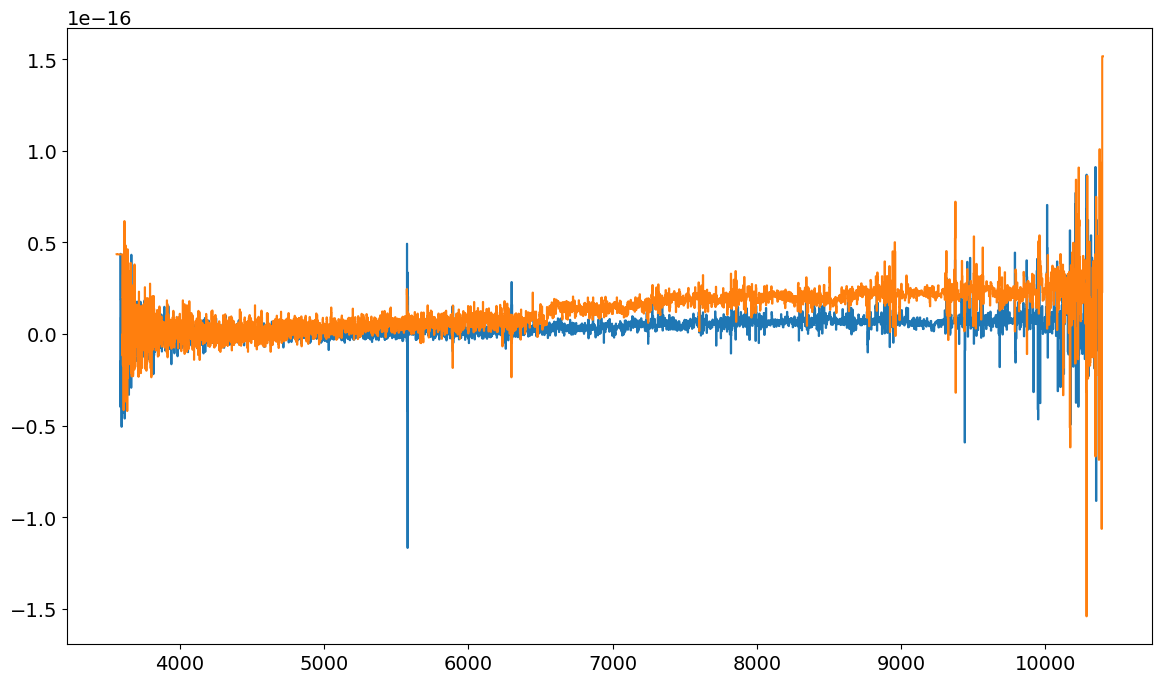

In [31]:
# Plot a couple
f, ax = plt.subplots()  
ax.step(specs[0].spectral_axis, specs[0].flux) 
ax.step(specs[1].spectral_axis, specs[1].flux)
plt.show()

<a class="anchor" id="plot"></a>
## Plot spectra

In [32]:
def plot_spec(index, results):
    """
    Pass an index value and the output from using client.retrieve()
    to plot the spectrum at the specified index.
    """
    
    record = results.records[index]

    sparcl_id = record.sparcl_id
    data_release = record.data_release
    flux = record.flux
    wavelength = record.wavelength
    model = record.model
    spectype = record.spectype
    redshift = record.redshift
    ra = record.ra
    dec = record.dec

    plt.title(f"Data Set = {data_release}\n"
              f"Type = {spectype}\n"
              f"ID = {sparcl_id}\n"
              f"Redshift = {redshift}\n"
              f"RA = {ra}\n"
              f"Dec = {dec}", loc='left')
    plt.xlabel('$\lambda\ [\AA]$')
    plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
    
    # Plot unsmoothed spectrum in grey
    plt.plot(wavelength, flux, color='k', alpha=0.2, label='Unsmoothed spectrum')
    
    # Overplot spectrum smoothed using a 1-D Gaussian Kernel in black
    plt.plot(wavelength, convolve(flux, Gaussian1DKernel(5)), color='k', label='Smoothed spectrum')
    
    # Overplot the model spectrum in red
    plt.plot(wavelength, model, color='r', label='Model spectrum')
    
    plt.legend()
    plt.show()

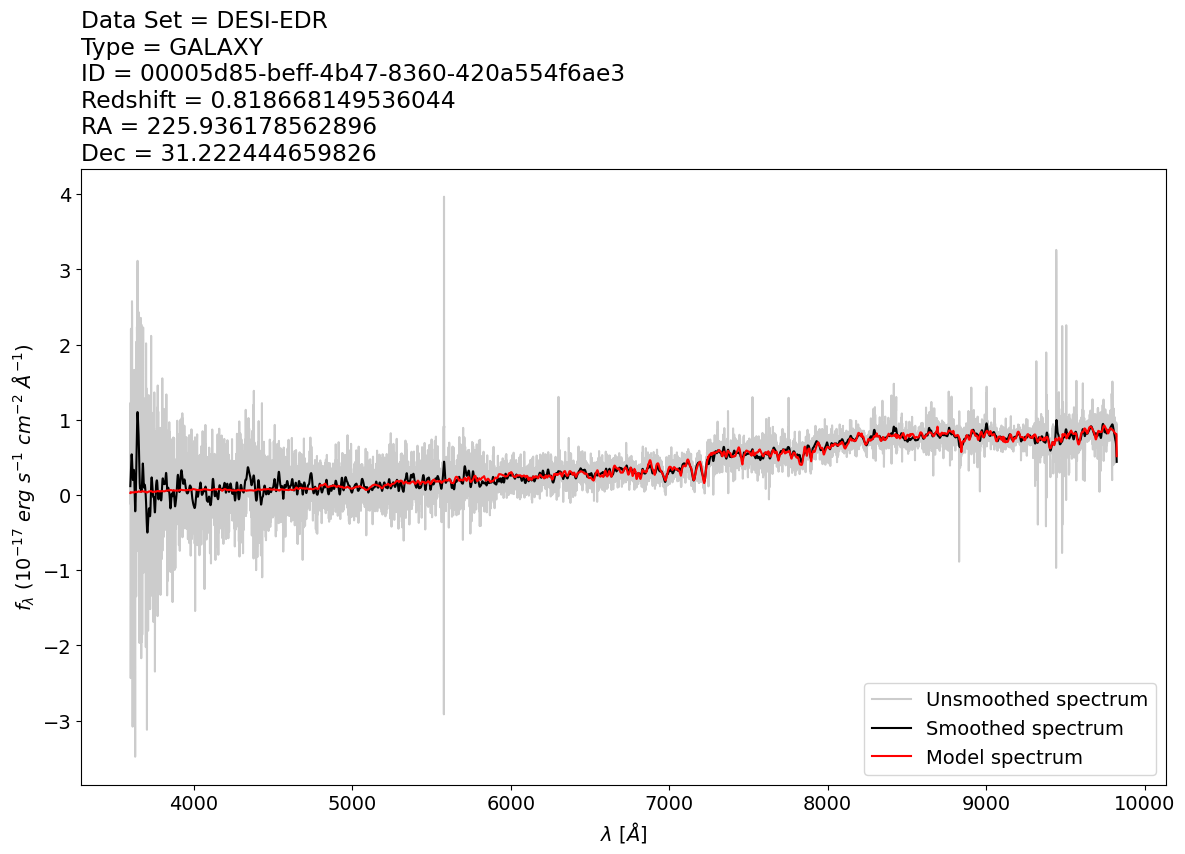

In [33]:
plot_spec(index=5, results=results_I)

<a class="anchor" id="missing"></a>
## Use `client.missing()` to find missing SPARCL IDs in the SPARCL database

In [34]:
client.missing?

Signature:
client.missing(
    uuid_list,
    *,
    dataset_list=None,
    countOnly=False,
    verbose=False,
)
Docstring:
Return the subset of sparcl_ids in the given uuid_list that are
NOT stored in the SPARC database.

Args:
    uuid_list (:obj:`list`): List of sparcl_ids.

    dataset_list (:obj:`list`, optional): List of data sets from
        which to find missing sparcl_ids. Defaults to None, meaning
        all data sets hosted on the SPARC database.

    countOnly (:obj:`bool`, optional): Set to True to return only
        a count of the missing sparcl_ids from the uuid_list.
        Defaults to False.

    verbose (:obj:`bool`, optional): Set to True for in-depth return
        statement. Defaults to False.

Returns:
    A list of the subset of sparcl_ids in the given uuid_list that
    are NOT stored in the SPARC database.

Example:
    >>> client = SparclClient()
    >>> ids = ['ddbb57ee-8e90-4a0d-823b-0f5d97028076',]
    >>> client.missing(ids)
    ['ddbb57ee-8e90-4a0d-8

#### When you try to retrieve records from the SPARCL database with IDs that do not exist in the SPARCL database, a warning message will appear:

In [35]:
ids_test = ['000025da-914b-4b67-b9a9-97cc811b0459',
            '0000fabc-0e15-4d76-b44c-4f152f31de09',
            '00001c20-b7ff-4367-af08-26432cd7e01d',
            '0000403e-51da-43b0-a0e9-e806ea31ca9e',
            'ddbb57ee-8e90-4a0d-823b-0f5d97028076']

res_test = client.retrieve(uuid_list=ids_test)

/var/folders/6j/v2lh3ssj13g6fs_lhk8nlps40000gp/T/ipykernel_93335/2568251338.py:7: UserWarning: Some UUIDs were not found. 3 out of the 5 requested uuids have no records available in the SPARC database associated with DataSets ['BOSS-DR16', 'SDSS-DR16', 'DESI-EDR'].Use "client.missing()" to get a list of the 3 unavailable uuids.
  res_test = client.retrieve(uuid_list=ids_test)


#### In order to figure out which of the IDs from your list do not exist in the SPARCL database, use the `client.missing()` method:

In [36]:
client.missing(uuid_list=ids_test)

['ddbb57ee-8e90-4a0d-823b-0f5d97028076',
 '000025da-914b-4b67-b9a9-97cc811b0459',
 '00001c20-b7ff-4367-af08-26432cd7e01d']